# 1B: Getting state from the fortran model from within Python

In this notebook we will illustrate how you can use the `fv3gfs.wrapper.get_state` method to access state of variables in the fortran model.

We'll start with some of the same boilerplate code from before.

## Recursively copy the contents of the example run directory to a clean folder in the docker container

We'll also override the input namelist of the reference run directory.

In [1]:
import os
import shutil

In [2]:
REFERENCE = "reference_rundir"
RUNDIR = "rundir_1B"

if os.path.isdir(RUNDIR):
    shutil.rmtree(RUNDIR)
shutil.copytree(REFERENCE, RUNDIR);

## Start the ipyparallel session for the notebook

This involves running a couple shell commands (hence the `%%bash` cell magic command at the top of the following cell); note this means these commands are executed in the shell rather than the notebook.

In [3]:
%%bash
# if you get a crash, add --debug to this command to put more info in logs
# logs are in /root/.ipython/profile_mpi/log
ipcluster start --profile=mpi -n 6 --daemonize
sleep 10  # command is asynchronous, so let's wait to avoid an error in the next cell

In [4]:
import ipyparallel as ipp
rc = ipp.Client(profile='mpi', targets='all', block=True)
dv = rc[:]
dv.activate()
dv.block = True

In [5]:
print("Running IPython Parallel on {0} MPI engines".format(len(rc.ids)))
print("Commands in the following cells will be executed in parallel (disable with %autopx)")
%autopx

Running IPython Parallel on 6 MPI engines
Commands in the following cells will be executed in parallel (disable with %autopx)
%autopx enabled


## Use `mpi4py` gain access to the communicator for the notebook.

In [6]:
from mpi4py import MPI

comm = MPI.COMM_WORLD

## Enter the run directory

Next we move into the run directory we created.  Note that we need to re-import `os` and re-define any variables we created before we started the cluster.  `fv3gfs.wrapper` requires that its routines are called from within a valid run directory.

In [7]:
import os
RUNDIR = "rundir_1B"
os.chdir(RUNDIR)

## Start by initializing the model

In [8]:
from fv3gfs import wrapper
wrapper.initialize()

## Before even running the model, we can illustrate the `get_state` command

After initializing the model we can obtain access to many of its fields through the `get_state` method. In its simplest form, `get_state` requires just a list of variable names.  A list of possible variable names we can get can be found in the metadata files within the fv3gfs-wrapper GitHub repository:

- [dynamics_properties.json](https://github.com/VulcanClimateModeling/fv3gfs-wrapper/blob/master/fv3gfs/wrapper/dynamics_properties.json)
- [physics_properties.json](https://github.com/VulcanClimateModeling/fv3gfs-wrapper/blob/master/fv3gfs/wrapper/physics_properties.json)

Tracers, e.g. `"specific_humidity"`, are handled in a special way, because they are dynamically set upon model initialization using the `field_table`.  For information about the tracers used by this particular simulation, use `fv3gfs.wrapper.get_tracer_metadata()`.

For instance we could obtain the `"surface_pressure"` field using `wrapper.get_state(["surface_pressure"])`.

In [9]:
state = wrapper.get_state(["surface_pressure"])

### What does this return?

`get_state` returns a dictionary mapping variable names to `fv3gfs.util.Quantity` objects.  For illustration we'll just print out what the result of the above cell was:

In [10]:
state

Out[0:5]: 
{'surface_pressure': Quantity(
     data=
 [[6.9112055e-310 6.9112055e-310 9.9376269e-316 ... 0.0000000e+000
   0.0000000e+000 0.0000000e+000]
  [0.0000000e+000 0.0000000e+000 0.0000000e+000 ... 0.0000000e+000
   0.0000000e+000 0.0000000e+000]
  [0.0000000e+000 0.0000000e+000 0.0000000e+000 ... 0.0000000e+000
   0.0000000e+000 0.0000000e+000]
  ...
  [0.0000000e+000 0.0000000e+000 0.0000000e+000 ... 0.0000000e+000
   0.0000000e+000 0.0000000e+000]
  [0.0000000e+000 0.0000000e+000 0.0000000e+000 ... 0.0000000e+000
   0.0000000e+000 0.0000000e+000]
  [0.0000000e+000 0.0000000e+000 0.0000000e+000 ... 0.0000000e+000
   0.0000000e+000 0.0000000e+000]],
     dims=('y', 'x'),
     units=Pa,
     origin=(3, 3),
     extent=(48, 48)
 )}

Out[1:5]: 
{'surface_pressure': Quantity(
     data=
 [[6.90278801e-310 9.99481837e-316 4.24381916e-316 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  ...
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]],
     dims=('y', 'x'),
     units=Pa,
     origin=(3, 3),
     extent=(48, 48)
 )}

Out[2:5]: 
{'surface_pressure': Quantity(
     data=
 [[6.91825148e-310 9.42770216e-316 9.42386900e-316 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  ...
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]],
     dims=('y', 'x'),
     units=Pa,
     origin=(3, 3),
     extent=(48, 48)
 )}

Out[3:5]: 
{'surface_pressure': Quantity(
     data=
 [[6.94961855e-310 9.60506935e-316 9.59735402e-316 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  ...
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]],
     dims=('y', 'x'),
     units=Pa,
     origin=(3, 3),
     extent=(48, 48)
 )}

Out[4:5]: 
{'surface_pressure': Quantity(
     data=
 [[6.9463285e-310 9.6007350e-316 4.7738615e-316 ... 0.0000000e+000
   0.0000000e+000 0.0000000e+000]
  [0.0000000e+000 0.0000000e+000 0.0000000e+000 ... 0.0000000e+000
   0.0000000e+000 0.0000000e+000]
  [0.0000000e+000 0.0000000e+000 0.0000000e+000 ... 0.0000000e+000
   0.0000000e+000 0.0000000e+000]
  ...
  [0.0000000e+000 0.0000000e+000 0.0000000e+000 ... 0.0000000e+000
   0.0000000e+000 0.0000000e+000]
  [0.0000000e+000 0.0000000e+000 0.0000000e+000 ... 0.0000000e+000
   0.0000000e+000 0.0000000e+000]
  [0.0000000e+000 0.0000000e+000 0.0000000e+000 ... 0.0000000e+000
   0.0000000e+000 0.0000000e+000]],
     dims=('y', 'x'),
     units=Pa,
     origin=(3, 3),
     extent=(48, 48)
 )}

Out[5:5]: 
{'surface_pressure': Quantity(
     data=
 [[6.94556651e-310 1.00571552e-315 1.00533221e-315 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  ...
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
   0.00000000e+000 0.00000000e+000]],
     dims=('y', 'x'),
     units=Pa,
     origin=(3, 3),
     extent=(48, 48)
 )}

We see that we have a state dictionary on each rank, each containing a `"surface_pressure"` variable.  An `fv3gfs.util.Quantity` object is a container for an array with metadata that describes the dimensions of the field it contains, as well as information about the size of the portion of the computational domain it represents in addition to the size of its halo regions.  

The domain decomposition is such that there is one cubed sphere tile per MPI rank, hence the `extent` of each compute domain is `(48, 48)`; the `origin` denotes the starting horizontal indices of the compute domain within raw data array that the `Quantity` contains (here since we are using the default number of halo points in FV3GFS, the origin is at `(3, 3)`).

The raw data (including halo points) a `Quantity` object contains can be accessed through the `data` attribute as a pure `np.ndarray`.  Note we can see some of the halo regions have not been initialized yet (they contain garbled values).

In [11]:
if comm.rank == 0: print(state["surface_pressure"].data)

[stdout:0] 
[[6.9112055e-310 6.9112055e-310 9.9376269e-316 ... 0.0000000e+000
  0.0000000e+000 0.0000000e+000]
 [0.0000000e+000 0.0000000e+000 0.0000000e+000 ... 0.0000000e+000
  0.0000000e+000 0.0000000e+000]
 [0.0000000e+000 0.0000000e+000 0.0000000e+000 ... 0.0000000e+000
  0.0000000e+000 0.0000000e+000]
 ...
 [0.0000000e+000 0.0000000e+000 0.0000000e+000 ... 0.0000000e+000
  0.0000000e+000 0.0000000e+000]
 [0.0000000e+000 0.0000000e+000 0.0000000e+000 ... 0.0000000e+000
  0.0000000e+000 0.0000000e+000]
 [0.0000000e+000 0.0000000e+000 0.0000000e+000 ... 0.0000000e+000
  0.0000000e+000 0.0000000e+000]]


If we want to view just the compute portion of the domain, we can use the `view` attribute of the quantity object.  This returns a NumPy array on each rank for just the compute domain.  Note that the `[:]` is required.  We need to specify which portion of the compute domain we want access. `[:]` indicates all the values; we could also select poritions (indices are relative to the compute domain boundaries).

In [12]:
if comm.rank == 0: print(state["surface_pressure"].view[:])

[stdout:0] 
[[101059.18188382 101096.90323849 101116.97270215 ... 102449.47012135
  102476.96503315 102494.18629518]
 [100204.42297611 101086.45393011 101189.03361909 ... 102224.11564928
  102265.14489345 102259.91228519]
 [ 99669.44407131 100942.16320114 101198.8306177  ... 102063.72180522
  102124.32597417 102149.30322019]
 ...
 [102406.28986313 102373.19296336 102357.57770745 ... 100565.91707173
  100665.72361039 100316.47253656]
 [102354.79946106 102307.16588005 102270.27330614 ... 100684.46873225
  100648.72111379 100439.0086575 ]
 [102225.80704029 102159.43289322 102097.99768333 ...  99748.33013979
  100276.88166677 100513.29371392]]


Here we are slicing along the y-dimension of the compute domain and selecting the 4th (recall Python is zero-indexed) value along the x-dimension of the compute domain:

In [13]:
if comm.rank == 0: print(state["surface_pressure"].view[1:5, 3])

[stdout:0] [101218.86032391 101243.24850032 101327.07554924 101566.83594979]


The order of the axes is given by the `dims` attribute:

In [14]:
if comm.rank == 0: print(state["surface_pressure"].dims)

[stdout:0] ('y', 'x')


### Creating a `Quantity` object from a NumPy array.

It is straightforward to create a `Quantity` object yourself.  This can sometimes be useful.  Initialization requires an array, a sequence of dimensions, and units.  Additional optional arguments include, `extent`, `origin`, and `gt4py_backend`.  As mentioned above, `extent` and `origin` relate to halo points and the distinction between the compute and haloed domain.  `gt4py_backend` is something we will not worry about for now.

The array that you provide the `Quantity` constructor includes any halo points.  Let's create a `Quantity` object with a single halo point in each horizontal dimension, whose compute domain is the same size as the compute domain for our current model configuration `(48, 48)`; we'll initialize it with zeros.

In [15]:
import fv3gfs.util
import numpy as np

In [16]:
array = np.zeros((50, 50))
quantity = fv3gfs.util.Quantity(
    array,
    origin=(1, 1),
    extent=(48, 48),
    dims=[fv3gfs.util.Y_DIM, fv3gfs.util.X_DIM],
    units="degK"
)

If we look at `quantity.data.shape` we see the full shape of the array (including the halo points).

In [17]:
quantity.data.shape

Out[0:12]: (50, 50)

Out[1:12]: (50, 50)

Out[2:12]: (50, 50)

Out[3:12]: (50, 50)

Out[4:12]: (50, 50)

Out[5:12]: (50, 50)

If we look at just `quantity.view[:].shape` we see just the compute domain.

In [18]:
quantity.view[:].shape

Out[0:13]: (48, 48)

Out[1:13]: (48, 48)

Out[2:13]: (48, 48)

Out[3:13]: (48, 48)

Out[4:13]: (48, 48)

Out[5:13]: (48, 48)

We can assing values to the compute domain as we would to a normal NumPy array:

In [20]:
quantity.view[:] = 1.0
if comm.rank == 0: print(quantity.data)

[stdout:0] 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [0. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Converting to DataArray objects

Quantity objects can be converted to `xarray.DataArray` objects through their `data_array` attribute.  `xarray.DataArray` are a more flexible/widely-used container for arrays of data.  They also contain metadata regarding the dimensions and units, so they can easily be converted back to `Quantity` objects.  It can sometimes be useful to go back and forth between these two representations of arrays.

Note, however, that when converting to a `DataArray`, `Quantity` objects lose their halo points.

In [21]:
if comm.rank == 0: print(state["surface_pressure"].data_array)

[stdout:0] 
<xarray.DataArray (y: 48, x: 48)>
array([[101059.18188382, 101096.90323849, 101116.97270215, ...,
        102449.47012135, 102476.96503315, 102494.18629518],
       [100204.42297611, 101086.45393011, 101189.03361909, ...,
        102224.11564928, 102265.14489345, 102259.91228519],
       [ 99669.44407131, 100942.16320114, 101198.8306177 , ...,
        102063.72180522, 102124.32597417, 102149.30322019],
       ...,
       [102406.28986313, 102373.19296336, 102357.57770745, ...,
        100565.91707173, 100665.72361039, 100316.47253656],
       [102354.79946106, 102307.16588005, 102270.27330614, ...,
        100684.46873225, 100648.72111379, 100439.0086575 ],
       [102225.80704029, 102159.43289322, 102097.99768333, ...,
         99748.33013979, 100276.88166677, 100513.29371392]])
Dimensions without coordinates: y, x
Attributes:
    units:    Pa


We can convert the `DataArray` back to a `Quantity` object using the `fv3gfs.util.Quantity.from_data_array` method.  We can see we get back a `Quantity`, but now the origin is located at `(0, 0)`, i.e. we lost the halo points.

In [22]:
if comm.rank == 0: print(fv3gfs.util.Quantity.from_data_array(state["surface_pressure"].data_array))

[stdout:0] 
Quantity(
    data=
[[101059.18188382 101096.90323849 101116.97270215 ... 102449.47012135
  102476.96503315 102494.18629518]
 [100204.42297611 101086.45393011 101189.03361909 ... 102224.11564928
  102265.14489345 102259.91228519]
 [ 99669.44407131 100942.16320114 101198.8306177  ... 102063.72180522
  102124.32597417 102149.30322019]
 ...
 [102406.28986313 102373.19296336 102357.57770745 ... 100565.91707173
  100665.72361039 100316.47253656]
 [102354.79946106 102307.16588005 102270.27330614 ... 100684.46873225
  100648.72111379 100439.0086575 ]
 [102225.80704029 102159.43289322 102097.99768333 ...  99748.33013979
  100276.88166677 100513.29371392]],
    dims=('y', 'x'),
    units=Pa,
    origin=(0, 0),
    extent=(48, 48)
)


### Quantity objects support slicing with named dimensions, but return NumPy arrays

In [23]:
if comm.rank == 0: print(state["surface_pressure"].sel(x=0))

[stdout:0] 
[101059.18188382 100204.42297611  99669.44407131  99063.6111172
  98329.88686833  97624.84093015  97306.42460503  97268.66855453
  97472.42009297  97054.18513786  96511.9603454   96541.77992948
  95731.38605173  95420.89638046  95977.4364925   97147.24555563
  97328.0012324   97192.07716309  97461.67345888  98075.14869491
  98492.78743541  99128.9381613   99948.9117034   97950.84563428
  97277.24117451  97913.70824123  99141.77557237 100418.43973702
 101201.49004954 101242.24681821 101269.35392014 101311.1684855
 101363.0436361  101439.00200029 101527.32843515 101614.19549934
 101709.04743622 101808.05611417 101893.70457407 101989.1400099
 102108.95699037 102216.66528849 102304.56019148 102373.32464139
 102419.6417956  102406.28986313 102354.79946106 102225.80704029]


### DataArray objects can make slicing along dimensions easier

It can be useful in some instances to slice a `Quantity` object and return a `Quantity` object in kind.  To do so we'll define a simple wrapper around converting a `Quantity` to a `DataArray`, indexing, and then converting back to a `Quantity`.  We can do this by using the `fv3gfs.util.Quantity.from_data_array` method.

In [24]:
def select(quantity, **indexers):
    selected = quantity.data_array.isel(indexers)
    return fv3gfs.util.Quantity.from_data_array(selected)

In [25]:
if comm.rank == 0: print(select(state["surface_pressure"], y=0))

[stdout:0] 
Quantity(
    data=
[101059.18188382 101096.90323849 101116.97270215 101052.57012484
 101036.2320509  101077.06609627 101185.39745401 101330.85948217
 101448.33983006 101550.85642806 101564.83215659 101502.9758725
 101430.15083078 101339.5564302  101238.01761302 101119.96025714
 101075.25478445 101118.33908574 101143.74844938 101150.34566863
 101151.82706788 101132.77452323 101072.74932827 101046.1206295
 101059.59020757 101065.6960298  101019.97239612 100936.18885005
 100876.59020389 100912.57139336 101000.83096697 101032.3181076
 100976.99840707 100929.58578383 101001.6856749  101225.1188356
 101409.27506116 101537.28107329 101562.30930993 101661.25343745
 101898.34637965 102090.50662239 102191.98053211 102272.54831547
 102382.99148317 102449.47012135 102476.96503315 102494.18629518],
    dims=('x',),
    units=Pa,
    origin=(0,),
    extent=(48,)
)


## Plotting the state

With a bit of `fv3gfs.util` magic we can gather the state from all MPI ranks and plot the result.  This is encapsulated in a function called `plot_global` we provided in a pre-written module.  Let's import that now.

`plot_global` takes in a 2D `Quantity` object, an MPI communicator, and a colorscale bounds.  Optionally, it takes in a `layout` parameter if you are running with more than the default 6 MPI ranks.  It handles gathering data from all MPI ranks on rank zero, and making a rough global plot (with the compute domains rotated and plotted in the correct places in a deconstructed cube).

In [26]:
from tools import plot_global
if comm.rank == 0: print(help(plot_global))

[stdout:0] 
Help on function plot_global in module tools:

plot_global(quantity, mpi_comm_world, vmin, vmax, layout=(1, 1))
    Plot a quantity globally on the root rank as a flattened cube.

None


[output:0]

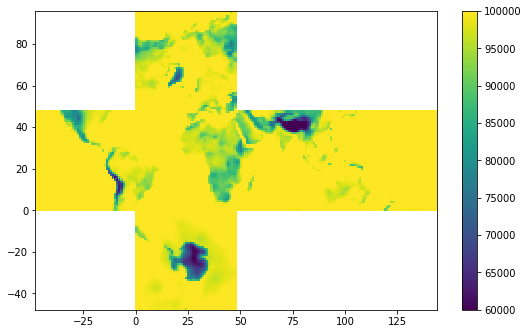

In [27]:
plot_global(state["surface_pressure"], comm, 60000, 100000)

Note that this plotting function only supports plotting 2D fields (i.e. fields defined in the x and y dimensions only).  To plot 3D fields, like `"air_temperature"`, we need to select horizontal slices first.  

## Exercise: plot a horizontal slice of a 3D field

Leveraging `get_state`, `select`, and `plot_global` functions, can you plot the temperature in the lowest model level?  Note that the `z` axis in the model is oriented from top to bottom.

## Exercise: compute a diagnostic using state from the fortran model

We can compute the mass-weighted integral of a tracer `q` by multiplying it by the pressure thickness and dividing by the gravitational acceleration:

$$ <q> = \frac{1}{g} \int q dp $$

Define a function that takes in two `Quantity` objects -- a tracer field and the pressure thickness -- and returns the mass-weighted integral of the tracer field as another `Quantity` object.  Look up the names of the fields for the pressure thickness in the [dynamics_properties.json](https://github.com/VulcanClimateModeling/fv3gfs-wrapper/blob/master/fv3gfs/wrapper/dynamics_properties.json) file in the fv3gfs-wrapper repository and find the cloud liquid water tracer name using `fv3gfs.wrapper.get_tracer_metadata()`, and use your new function to compute the column-integrated cloud liquid water.  Plot the result using `plot_global` (it should look something like clouds!).

Hint: `Quantity` objects do not support arithmetic natively; you will need to pull out the underlying arrays. There are multiple ways you could do this.  If you are familiar with xarray you might prefer to go the route of converting the input Quantities to DataArrays first, but if you are more comfortable with NumPy you may prefer to use the `Quantity.view[:]` syntax to operate on NumPy arrays directly and construct a `Quantity` object from the result.  Reasonable colorbar bounds for this quantity are `0.0` and `0.1`.

## Exercise: step the model forward a few timesteps and plot the column integrated cloud liquid water again

## Something else you can try if you have time

Compute and plot the tendency of specific humidity due to the dynamics by taking the difference between the state before and after `step_dynamics` is called and dividing by the timestep.  Do the same for the physics tendency.  How do they compare?